# Adaptive Learning


In [1]:
!pip install scikit-optimize


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.9 MB/s eta 0:00:00


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from skopt import gp_minimize
from skopt.plots import plot_convergence

import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from skopt import gp_minimize
from skopt.plots import plot_convergence

import os
import glob
import pandas as pd

import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ExpSineSquared, RationalQuadratic, Matern, Product, ConstantKernel as C
from collections import defaultdict
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from pandas.plotting import parallel_coordinates
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import f_oneway


In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)  # Approve the authentication prompts as needed

Mounted at /content/drive


In [6]:
# Define the path again (since Colab was reset)
file_path = '/content/drive/MyDrive/Thesis_Updated/AI_Data/material_with_simulated_sparams_extended.csv'

# Load the dataset
material_df = pd.read_csv(file_path)

# Calculate sigma
epsilon_0 = 8.854187817e-12  # Vacuum permittivity
material_df['sigma'] = 2 * np.pi * material_df['frequency'] * material_df['epsilon_imag'] * epsilon_0

# Calculate Reflection (R), Transmission (T), Absorption (A)
material_df['R'] = np.abs(material_df['s11'])**2
material_df['T'] = np.abs(material_df['s21'])**2
material_df['A'] = 1 - material_df['R'] - material_df['T']

# Split into ABS and PBT sets
abs_df = material_df[material_df['material'] == 'ABS'].copy()
pbt_df = material_df[material_df['material'] == 'PBT'].copy()

# Display shapes to confirm data loaded and processed
abs_df.shape, pbt_df.shape

((1500, 16), (2200, 16))

In [9]:
pbt_df

,frequency,epsilon_real,epsilon_imag,mu_real,mu_imag,s11,s21,cnt_pct,material,thickness,sim_s11,sim_s21,sigma,R,T,A
0,1.240000e+10,12.70,6.38,1.0,0.0,0.867,0.0453,4,PBT,2.0,(0.4118538830333252+0.5367021727144117j),(-0.06359360063033916+0.002812148330820263j),4.401199,0.751689,0.002052,0.246259
1,1.245657e+10,12.40,6.13,1.0,0.0,0.864,0.0453,4,PBT,2.0,(0.6680739762552288-0.09138455596778536j),(-0.027086098474567243+0.05803735213368467j),4.248028,0.746496,0.002052,0.251452
2,1.251313e+10,12.60,6.13,1.0,0.0,0.865,0.0453,4,PBT,2.0,(0.251023359568624-0.6227292027028055j),(0.03900188039983329+0.051324052982221965j),4.267319,0.748225,0.002052,0.249723
3,1.256970e+10,12.40,5.99,1.0,0.0,0.866,0.0453,4,PBT,2.0,(-0.41368345561678715-0.52546181037544j),(0.0638647553208774-0.010383439653720641j),4.188709,0.749956,0.002052,0.247992
4,1.262626e+10,12.60,6.19,1.0,0.0,0.863,0.0453,4,PBT,2.0,(-0.6608744646995178+0.09196007277300257j),(0.021280345222035223-0.061147642701106196j),4.348045,0.744769,0.002052,0.253179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3695,1.777374e+10,6.17,4.59,1.0,0.0,0.724,0.1910,2,PBT,2.0,(-0.5148384855755164-0.3203924294922376j),(-0.01656332844941245+0.01341111190993133j),4.538580,0.524176,0.036481,0.439343
3696,1.783030e+10,6.15,4.74,1.0,0.0,0.718,0.1900,2,PBT,2.0,(-0.5872836642844584+0.15671523602834794j),(-0.0009449056919313924+0.021243892005975006j),4.701816,0.515524,0.036100,0.448376
3697,1.788687e+10,6.17,4.53,1.0,0.0,0.719,0.1900,2,PBT,2.0,(-0.2928715183359006+0.5348761597035523j),(0.015211279956772114+0.014778499918532317j),4.507763,0.516961,0.036100,0.446939
3698,1.794343e+10,6.09,4.63,1.0,0.0,0.718,0.1900,2,PBT,2.0,(0.18006020874502612+0.5837701363091489j),(0.021087172866037323-0.0015130905743989316j),4.621843,0.515524,0.036100,0.448376


In [10]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RationalQuadratic, ConstantKernel as C
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import numpy as np

# Features and targets
input_features = ["cnt_pct", "thickness", "frequency", "epsilon_real", "sigma"]
output_targets = ["A", "R", "T"]

# Helper function to train GPR model
def train_gpr_model(df, name="Material"):
    print(f"🛠️ Training GPR model for {name} ...")

    X = df[input_features].values
    y = df[output_targets].values

    # Define a RationalQuadratic kernel with initial hyperparameters
    kernel = C(1.0, (1e-2, 1e3)) * RationalQuadratic(length_scale=1.0, alpha=0.1)

    # Build a pipeline with scaling and multi-output GPR
    gpr = make_pipeline(
        StandardScaler(),
        MultiOutputRegressor(GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y=True))
    )

    gpr.fit(X, y)
    print(f"✅ GPR training complete for {name}")
    return gpr

# Train models
abs_gpr = train_gpr_model(abs_df, name="ABS")
pbt_gpr = train_gpr_model(pbt_df, name="PBT")


🛠️ Training GPR model for ABS ...
✅ GPR training complete for ABS
🛠️ Training GPR model for PBT ...
✅ GPR training complete for PBT


In [13]:
import os
import joblib
from datetime import datetime

def save_sklearn_gpr_model(model, material_name, base_path='/content/drive/MyDrive/Thesis_Updated/Models/GPR'):
    """
    Saves the trained scikit-learn GPR model (wrapped in a pipeline) with a timestamped filename.

    Parameters:
    - model: The pipeline containing StandardScaler + MultiOutputRegressor(GPR)
    - material_name: str, e.g., "ABS", "PBT"
    - base_path: target directory in Google Drive
    """
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"{material_name}_GPR_Sklearn_{timestamp}.pkl"
    save_path = os.path.join(base_path, filename)

    # Ensure directory exists
    os.makedirs(base_path, exist_ok=True)

    # Save with joblib
    joblib.dump({
        'model': model,
        'material': material_name,
        'timestamp': timestamp
    }, save_path)

    print(f"✅ Sklearn GPR model for {material_name} saved to: {save_path}")

save_sklearn_gpr_model(abs_gpr, "ABS")
save_sklearn_gpr_model(pbt_gpr, "PBT")


✅ Sklearn GPR model for ABS saved to: /content/drive/MyDrive/Thesis_Updated/Models/GPR/ABS_GPR_Sklearn_20250403_172200.pkl
✅ Sklearn GPR model for PBT saved to: /content/drive/MyDrive/Thesis_Updated/Models/GPR/PBT_GPR_Sklearn_20250403_172200.pkl


In [17]:
def get_mean_uncertainty(gpr_model, df, material_name, top_n=30):
    """
    Estimate uncertainty using the standard deviation of the GPR prediction
    for absorption (target index 0) without averaging across frequency.

    Returns top_n most uncertain (cnt_pct, thickness) combinations.
    """
    print(f"\n🔍 Estimating uncertainty for {material_name} ...")

    X = df[input_features].values

    # Extract the first model (for Absorption) from the multi-output regressor
    gpr_abs = gpr_model.named_steps['multioutputregressor'].estimators_[0]

    # Predict mean and std
    _, std = gpr_abs.predict(X, return_std=True)
    df = df.copy()  # Avoid modifying original
    df["uncertainty"] = std

    # Sort by uncertainty (highest first) and drop duplicates for (cnt_pct, thickness)
    sorted_df = df.sort_values("uncertainty", ascending=False)
    top_combos = sorted_df[["cnt_pct", "thickness", "uncertainty"]].drop_duplicates(subset=["cnt_pct", "thickness"])

    top_combos = top_combos.reset_index(drop=True).head(top_n)
    print(f"✅ Top {top_n} uncertain combinations for {material_name}:\n", top_combos)

    return top_combos


# Step 5: Run for both materials
top3_abs = get_mean_uncertainty(abs_gpr, abs_df, "ABS")
top3_pbt = get_mean_uncertainty(pbt_gpr, pbt_df, "PBT")


🔍 Estimating uncertainty for ABS ...
✅ Top 30 uncertain combinations for ABS:
    cnt_pct  thickness  uncertainty
0        1        2.8     0.076966
1        3        1.1     0.076966
2        3        2.8     0.076966
3        5        2.8     0.076966

🔍 Estimating uncertainty for PBT ...
✅ Top 30 uncertain combinations for PBT:
     cnt_pct  thickness  uncertainty
0         1        0.9     0.085123
1         1        0.6     0.085123
2         1        0.8     0.085123
3         1        1.1     0.085123
4         1        1.5     0.085123
5         7        2.8     0.085123
6         1        2.0     0.085123
7         1        1.0     0.085123
8         5        2.8     0.085123
9         4        2.0     0.085123
10        5        2.0     0.085123
11        2        2.0     0.085123
12        7        2.0     0.085123
13        3        2.8     0.085123
14        1        2.8     0.085123
15        3        2.0     0.085123
16        1        1.2     0.085123


In [23]:
import numpy as np
import pandas as pd
from itertools import product

def get_top_uncertain_points_grid(gpr_model, seen_df, material_name, fixed_freq=15.2e9,
                                   fixed_eps=6.0, fixed_sigma=2.0, top_n=10):
    print(f"\n🔍 Estimating uncertainty on unseen grid for {material_name} ...")

    # 1. Create parameter grid
    cnt_range = np.arange(0, 7.5 + 0.1, 0.5)
    thick_range = np.arange(0.5, 2.8 + 0.01, 0.1)

    grid = pd.DataFrame(list(product(cnt_range, thick_range)),
                        columns=["cnt_pct", "thickness"])

    # Add fixed columns
    grid["frequency"] = fixed_freq
    grid["epsilon_real"] = fixed_eps
    grid["sigma"] = fixed_sigma

    # 2. Remove already seen combinations
    seen_combos = seen_df[["cnt_pct", "thickness"]].drop_duplicates()
    grid = grid.merge(seen_combos, on=["cnt_pct", "thickness"], how="left", indicator=True)
    unseen_grid = grid[grid["_merge"] == "left_only"].drop(columns=["_merge"])

    print(f"📐 Unseen combinations to test: {len(unseen_grid)}")

    # 3. Predict uncertainty using std
    X_grid = unseen_grid[["cnt_pct", "thickness", "frequency", "epsilon_real", "sigma"]].values
    _, stds = zip(*[estimator.predict(X_grid, return_std=True)
                    for estimator in gpr_model.named_steps['multioutputregressor'].estimators_])

    print(len(stds))
    stds = np.vstack(stds).T  # shape: (n_samples, 3)

    unseen_grid["uncertainty_A"] = stds[:, 0]
    unseen_grid["uncertainty_R"] = stds[:, 1]
    unseen_grid["uncertainty_T"] = stds[:, 2]

    print(stds.shape)

    # 4. Average uncertainty across all outputs (Abs, Ref, Trans)
    unseen_grid["uncertainty"] = stds.mean(axis=1)

    # 5. Sort and return top N
    top = unseen_grid.sort_values("uncertainty_A", ascending=False).reset_index(drop=True)
    print(f"✅ Top {top_n} uncertain combinations for {material_name}:\n", top)

    return top

# Example usage:
top_abs = get_top_uncertain_points_grid(abs_gpr, abs_df, "ABS", fixed_eps=6.0, fixed_sigma=2.0, top_n=10)
top_pbt = get_top_uncertain_points_grid(pbt_gpr, pbt_df, "PBT", fixed_eps=12.0, fixed_sigma=4.0, top_n=10)



🔍 Estimating uncertainty on unseen grid for ABS ...
📐 Unseen combinations to test: 384
3
(384, 3)
✅ Top 10 uncertain combinations for ABS:
      cnt_pct  thickness     frequency  epsilon_real  sigma  uncertainty_A  \
0        7.5        1.2  1.520000e+10           6.0    2.0       0.076726   
1        7.5        1.1  1.520000e+10           6.0    2.0       0.076726   
2        7.5        1.0  1.520000e+10           6.0    2.0       0.076726   
3        7.5        0.9  1.520000e+10           6.0    2.0       0.076726   
4        7.5        0.8  1.520000e+10           6.0    2.0       0.076726   
..       ...        ...           ...           ...    ...            ...   
379      0.0        0.9  1.520000e+10           6.0    2.0       0.076726   
380      0.0        0.8  1.520000e+10           6.0    2.0       0.076726   
381      0.0        0.7  1.520000e+10           6.0    2.0       0.076726   
382      0.0        0.6  1.520000e+10           6.0    2.0       0.076726   
383      0.0

In [34]:
import pandas as pd
import numpy as np

def select_high_uncertainty_points_df(model, original_df, input_features, output_names, k=5):
    # Unpack the pipeline
    scaler = model.named_steps['standardscaler']
    multi_gpr = model.named_steps['multioutputregressor']

    # Get candidate inputs
    X_candidates = original_df[input_features].values
    X_scaled = scaler.transform(X_candidates)

    # Get std devs per output
    stds = []
    for est in multi_gpr.estimators_:
        _, std = est.predict(X_scaled, return_std=True)
        stds.append(std)

    std_matrix = np.stack(stds, axis=1)  # shape (n_samples, n_outputs)
    std_sum = std_matrix.sum(axis=1)

    # Get top-k indices
    top_k_indices = np.argsort(std_sum)[-k:]

    # Build DataFrame
    top_df = original_df.iloc[top_k_indices][input_features].copy()
    for i, out in enumerate(output_names):
        top_df[f'std_{out}'] = std_matrix[top_k_indices, i]
    top_df["std_total"] = std_sum[top_k_indices]

    return top_df.sort_values("std_total", ascending=False).reset_index(drop=True)
input_features = ["cnt_pct", "thickness", "frequency", "epsilon_real", "sigma"]
output_targets = ["A", "R", "T"]

top_abs_df = select_high_uncertainty_points_df(abs_gpr, abs_df, input_features, output_targets, k=50)
top_pbt_df = select_high_uncertainty_points_df(pbt_gpr, pbt_df, input_features, output_targets, k=50)


In [36]:
def get_top_unique_cnt_thickness(df, k=5):
    # Group by cnt_pct and thickness, then keep the row with the highest std_total per group
    grouped = df.groupby(['cnt_pct', 'thickness'], as_index=False).apply(
        lambda x: x.sort_values('std_total', ascending=False).head(1)
    ).reset_index(drop=True)

    # Sort all unique combinations by std_total and pick top k
    top_unique = grouped.sort_values('std_total', ascending=False).head(k).reset_index(drop=True)
    return top_unique[['cnt_pct', 'thickness', 'std_A', 'std_R', 'std_T', 'std_total']]
top_abs_combos = get_top_unique_cnt_thickness(top_abs_df, k=5)
top_pbt_combos = get_top_unique_cnt_thickness(top_pbt_df, k=5)


<ipython-input-36-68ad6423c443>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df.groupby(['cnt_pct', 'thickness'], as_index=False).apply(
<ipython-input-36-68ad6423c443>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df.groupby(['cnt_pct', 'thickness'], as_index=False).apply(


In [37]:
top_abs_combos

,cnt_pct,thickness,std_A,std_R,std_T,std_total
0,3,2.8,8.073845e-07,0.000001,6.741358e-07,0.000003
1,3,1.1,8.073630e-07,0.000001,6.741597e-07,0.000003
2,1,2.8,8.073200e-07,0.000001,6.741478e-07,0.000003
3,5,2.8,8.073200e-07,0.000001,6.741358e-07,0.000003


In [43]:
# Grid ranges
cnt_vals = np.arange(0.0, 7.1, 0.5)        # 0.0 to 7.0 inclusive
thickness_vals = np.arange(0.5, 3.1, 0.1)  # 0.5 to 3.0 inclusive

# Create full grid of combinations
grid = list(product(cnt_vals, thickness_vals))
grid_df = pd.DataFrame(grid, columns=["cnt_pct", "thickness"])

def prepare_candidate_inputs(grid_df, ref_df):
    default_freq = 15e9
    default_eps = ref_df['epsilon_real'].mean()
    default_sigma = ref_df['sigma'].mean()

    grid_df['frequency'] = default_freq
    grid_df['epsilon_real'] = default_eps
    grid_df['sigma'] = default_sigma
    return grid_df[input_features]
abs_candidates_df = prepare_candidate_inputs(grid_df.copy(), abs_df)
pbt_candidates_df = prepare_candidate_inputs(grid_df.copy(), pbt_df)


def evaluate_uncertainty_over_candidates(model, input_df, input_features, output_names, full_metadata_df, k=5):
    scaler = model.named_steps['standardscaler']
    multi_gpr = model.named_steps['multioutputregressor']

    X_scaled = scaler.transform(input_df[input_features].values)

    stds = []
    for est in multi_gpr.estimators_:
        _, std = est.predict(X_scaled, return_std=True)
        stds.append(std)

    std_matrix = np.stack(stds, axis=1)
    std_sum = std_matrix.sum(axis=1)

    # Build DataFrame
    df_out = full_metadata_df.copy()
    for i, out in enumerate(output_names):
        df_out[f'std_{out}'] = std_matrix[:, i]
    df_out["std_total"] = std_sum

    # Group by cnt_pct and thickness to find unique uncertainty combos
    grouped = df_out.groupby(['cnt_pct', 'thickness'], as_index=False).apply(
        lambda x: x.sort_values('std_total', ascending=False).head(1)
    ).reset_index(drop=True)

    top_unique = grouped.sort_values('std_total', ascending=False).head(k).reset_index(drop=True)
    return top_unique[['cnt_pct', 'thickness', 'std_A', 'std_R', 'std_T', 'std_total']]

top_abs_unseen = evaluate_uncertainty_over_candidates(
    abs_gpr, abs_candidates_df, input_features, output_targets, grid_df, k=100
)

top_pbt_unseen = evaluate_uncertainty_over_candidates(
    pbt_gpr, pbt_candidates_df, input_features, output_targets, grid_df, k=100
)

top_abs_unseen

<ipython-input-43-b7ca00105d32>:43: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df_out.groupby(['cnt_pct', 'thickness'], as_index=False).apply(
<ipython-input-43-b7ca00105d32>:43: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df_out.groupby(['cnt_pct', 'thickness'], as_index=False).apply(


,cnt_pct,thickness,std_A,std_R,std_T,std_total
0,7.0,0.5,0.030937,0.038190,0.021222,0.090349
1,7.0,0.6,0.030888,0.038123,0.021164,0.090175
2,7.0,0.7,0.030840,0.038056,0.021106,0.090002
3,7.0,0.8,0.030793,0.037990,0.021049,0.089832
4,7.0,0.9,0.030746,0.037925,0.020992,0.089663
...,...,...,...,...,...,...
95,6.5,2.5,0.029717,0.036484,0.019702,0.085904
96,5.0,0.8,0.029710,0.036473,0.019715,0.085897
97,6.5,2.8,0.029712,0.036478,0.019692,0.085882
98,1.0,0.8,0.029704,0.036464,0.019709,0.085877


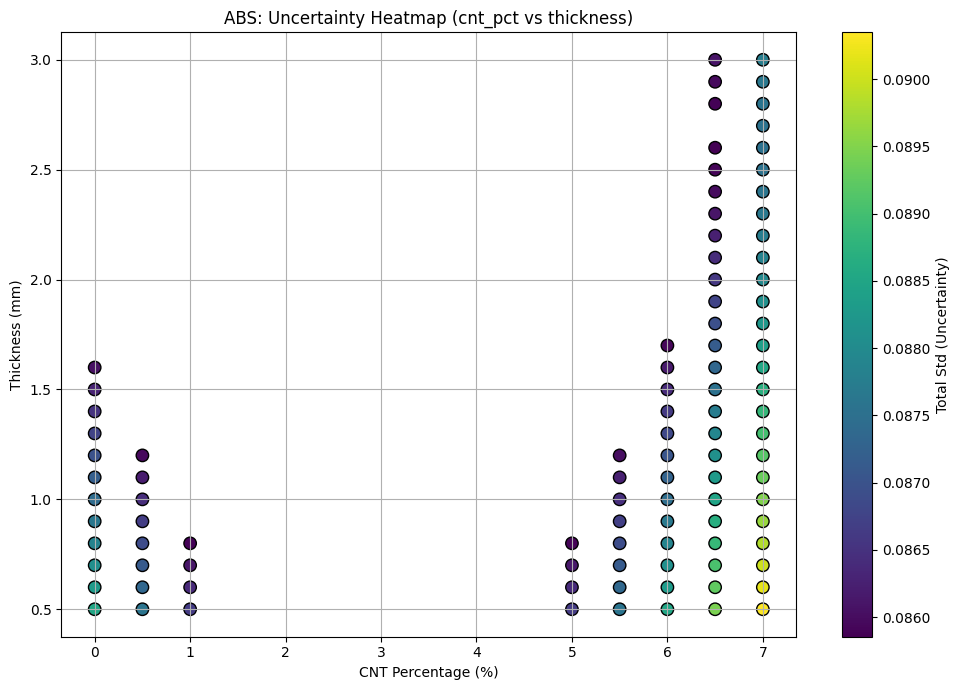

Top 5 Diverse High-Uncertainty Points (ABS):
    cnt_pct  thickness  std_total
0       6.0        0.7   0.088096
1       0.0        0.9   0.087640
2       7.0        1.7   0.088380
3       7.0        3.0   0.087755
4       7.0        1.2   0.089166
5       5.5        0.5   0.087589
6       7.0        0.5   0.090349
7       6.5        1.5   0.087527
8       0.5        0.5   0.087577
9       0.0        1.0   0.087424
10      7.0        0.8   0.089832
11      7.0        2.2   0.087746
12      0.0        0.5   0.088507
13      0.0        1.3   0.086758
14      6.0        1.1   0.087259


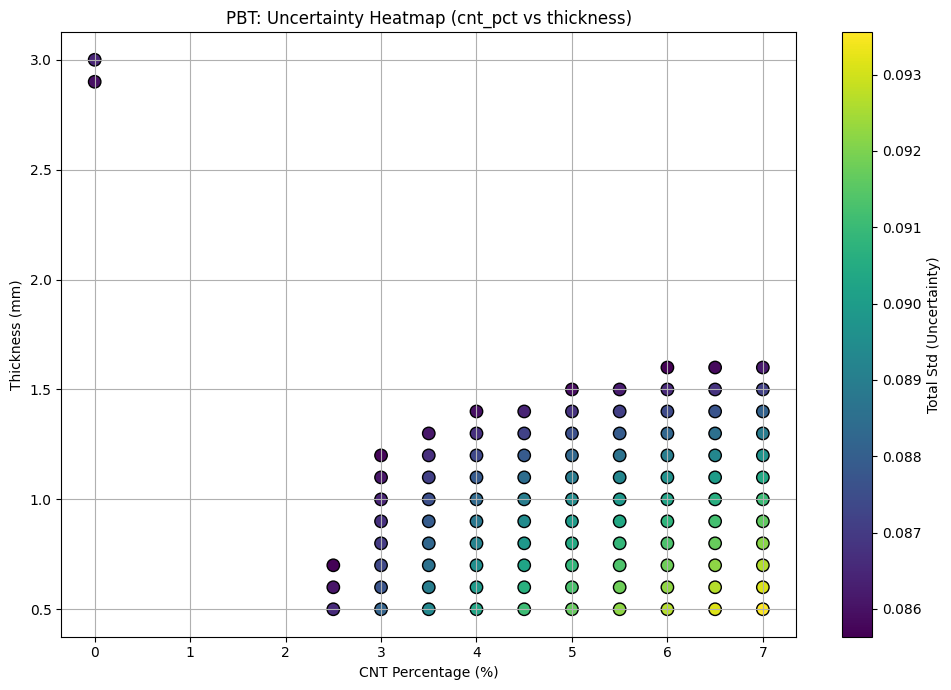

Top 5 Diverse High-Uncertainty Points (ABS):
    cnt_pct  thickness  std_total
0       7.0        1.0   0.091025
1       3.5        0.8   0.088244
2       0.0        3.0   0.086439
3       5.5        1.2   0.088627
4       6.5        0.5   0.093124
5       4.5        0.9   0.089429
6       4.5        0.5   0.091054
7       3.5        0.5   0.089338
8       7.0        0.5   0.093554
9       4.0        1.2   0.087363
10      6.0        1.0   0.090237
11      7.0        1.4   0.088081
12      5.5        0.8   0.090893
13      5.0        1.2   0.088275
14      5.5        0.5   0.092211


In [45]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

def plot_uncertainty_2d(df, x_col='cnt_pct', y_col='thickness', c_col='std_total', title="Uncertainty Heatmap"):
    plt.figure(figsize=(10, 7))
    sc = plt.scatter(df[x_col], df[y_col], c=df[c_col],
                     cmap='viridis', s=80, edgecolor='black')
    plt.colorbar(sc, label='Total Std (Uncertainty)')
    plt.title(title)
    plt.xlabel('CNT Percentage (%)')
    plt.ylabel('Thickness (mm)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def select_diverse_uncertain_points(df, k=5, weight_uncertainty=0.8):
    # Normalize cnt_pct and thickness
    scaler = MinMaxScaler()
    normalized_coords = scaler.fit_transform(df[['cnt_pct', 'thickness']])

    # Add weighted uncertainty as a 3rd dimension
    weighted_features = np.hstack([
        normalized_coords,
        df['std_total'].values.reshape(-1, 1) * weight_uncertainty  # Adjust weight if needed
    ])

    # KMeans clustering for diversity
    kmeans = KMeans(n_clusters=k, random_state=42)
    df['cluster'] = kmeans.fit_predict(weighted_features)

    # Pick the most uncertain point in each cluster
    top_diverse = df.loc[df.groupby('cluster')['std_total'].idxmax()].reset_index(drop=True)
    return top_diverse

# Step 1: Plot
plot_uncertainty_2d(top_abs_unseen, title="ABS: Uncertainty Heatmap (cnt_pct vs thickness)")

# Step 2: Get diverse + high-uncertainty samples
diverse_top5_abs = select_diverse_uncertain_points(top_abs_unseen, k=15)

# View the result
print("Top 5 Diverse High-Uncertainty Points (ABS):")
print(diverse_top5_abs[['cnt_pct', 'thickness', 'std_total']])


# Step 1: Plot
plot_uncertainty_2d(top_pbt_unseen, title="PBT: Uncertainty Heatmap (cnt_pct vs thickness)")

# Step 2: Get diverse + high-uncertainty samples
diverse_top5_pbt = select_diverse_uncertain_points(top_pbt_unseen, k=15)

# View the result
print("Top 5 Diverse High-Uncertainty Points (ABS):")
print(diverse_top5_pbt[['cnt_pct', 'thickness', 'std_total']])

In [42]:
top_pbt_unseen

,cnt_pct,thickness,std_A,std_R,std_T,std_total
0,7.0,0.5,0.032937,0.041751,0.018865,0.093554
1,6.5,0.5,0.032814,0.041586,0.018724,0.093124
2,7.0,0.6,0.032812,0.041583,0.018719,0.093114
3,6.5,0.6,0.032689,0.041418,0.018578,0.092685
4,6.0,0.5,0.032688,0.041417,0.018579,0.092683


In [11]:
import os
import joblib
import torch
from datetime import datetime

def save_multioutput_gpr_models(models, scaler, material_name, base_path='/content/drive/MyDrive/Thesis_Updated/Models/GPR'):
    """
    Saves a list of trained GPR models (one per output: A, R, T) along with the StandardScaler
    to a timestamped file in the specified folder.

    Parameters:
    - models: list of (model, likelihood) tuples
    - scaler: StandardScaler object used for inputs
    - material_name: string, name of material (e.g., "ABS", "PBT")
    - base_path: directory to save the model
    """
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"{material_name}_GPR_Models_{timestamp}.pt"
    save_path = os.path.join(base_path, filename)

    # Ensure the directory exists
    os.makedirs(base_path, exist_ok=True)

    # Collect model and likelihood state dicts
    model_data = {
        'models': [model.state_dict() for model, _ in models],
        'likelihoods': [likelihood.state_dict() for _, likelihood in models],
        'scaler': scaler,
        'material': material_name,
        'timestamp': timestamp
    }

    # Save everything using torch
    torch.save(model_data, save_path)
    print(f"✅ Saved GPR models for {material_name} at: {save_path}")


In [12]:
save_multioutput_gpr_models(abs_gpr, "ABS")
save_multioutput_gpr_models(pbt_gpr, "PBT")

NameError: name 'abs_models' is not defined